**Sentiment analysis project**

**In this notebook, we present the training process of different multilingual language models for a sentiment analysis task.**
The goal of this work is to deliver a sentiment-analysis model with "acceptable" performances ready-to be used. I am aware that further optimization can be applied.
---



In this work we will use two different transformer models:
1. [xlm-roberta](https://arxiv.org/pdf/1911.02116.pdf)
2. [deberta](https://arxiv.org/abs/2006.03654) with its multilingual version <br>
Originally, those two models were pre-trained on the same corpus CC-100. However, we will use two variants of xlm-r: the original version that was only pre-trained on CC-100 that we call **xlm-r original** and one, that we call **xlm-r tweets** that was obtained by further pre-training the original version on a 190M tweets and fine-tuned on sentiment analysis task. <br>


## **Installing libraries**

Before starting, lets install the required libraries that are not all-ready installed in the google colaboratory kernel.


In [1]:
!pip install -q transformers
!pip install sentencepiece
!pip install langdetect

     |████████████████████████████████| 3.4 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 61 kB 287 kB/s 
     |████████████████████████████████| 3.3 MB 32.8 MB/s 
     |████████████████████████████████| 895 kB 42.7 MB/s 
     |████████████████████████████████| 1.2 MB 6.7 MB/s 
     |████████████████████████████████| 981 kB 8.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=fa3657419b895522ca07bda1ac92a3f71cdb2d876c9963c086ce15ba2b29f7b6
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


## **Importing libraries and connecting the drive for the data import**

In [2]:

import transformers
import torch
from torch.utils.data import DataLoader
from torch import cuda

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn import metrics

import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd



Mounting the google drive in order to import the data


In [3]:
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/MyDrive/Synthesio')

Mounted at /content/drive



# **Reading and preparing the data**


In [4]:
df = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
df = df[df['sentiment'] != 'unassigned']

**Data preparation**




1.   We start by splitting the data into two parts: train dataset (80%) and validation dataset (20%). The first one is used to fine-tune the different models and the second one is only used to evaluate the models in order to apply early stopping and to compare of the final results of the models.
2. In order to adapt those datasets to the models' input format: 

*   we apply the ordinal encoding to categories/sentiments using a categories_encoding dictionary.
*   we use a pre-trained tokenizer to encode the text in the adequate input format of each pre-trained language model. <br>

3.   we create data loaders for both dataset with **batch size=8** which helps parallelizing the learning process.


NB1: we chose the maximal batch size that allows us to make the experiments with the available gpu on google collaboratory. Feel free to increase this value if you have more gpu memory.

NB2: no data pre-processing is done before passing the text to the tokenizers.

In [5]:
categories_encoding = {'negative': 0, 'neutral':1, 'positive':2 }
df['sentiment'] = df['sentiment'].replace(categories_encoding)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
df.head()

,content,sentiment
0,Не подошло.,0
1,"товара нет, деньги вернул",0
2,"[옵션]문풍지종류선택:3M실내용,규격선택:4. 대형",1
3,Kirain Alice rokoknya esse change wkwk,1
4,El hotel ideal para descansar y relajarte. El ...,2


Splitting the data into 2 parts train, validation and creating the dataloaders

In [7]:
def create_dataset(data, tokenizer, max_length=512):

  X_train, X_val, Y_train, Y_val = train_test_split(list(data['content']), 
                                                      data['sentiment'],
                                                      test_size=0.2,
                                                      random_state=42)
  
  Y_train.index = range(len(Y_train))
  Y_val.index = range(len(Y_val))
  train_encodings = tokenizer(X_train,
                              truncation=True,
                              padding=True, 
                              max_length=max_length)
  val_encodings = tokenizer(X_val,
                            truncation=True,
                            padding=True,
                            max_length=max_length)

  return train_encodings, np.array(Y_train), val_encodings, np.array(Y_val)




In [8]:
class Sentiment_analysis_dataset(torch.utils.data.Dataset):

  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  
  def __getitem__(self, idx):
    item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item
  
  def __len__(self):
    return len(self.labels)
    

In [9]:
train_params = {'batch_size': 8,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': 8,
                'shuffle': False,
                'num_workers': 0
                }
device = 'cuda' if torch.cuda.is_available() else 'cpu'


**Training  details**

We define and train all the models following the same plan:


*   We adapt the language model to the downstream task by adding a dropout and a fully connected layer on top of the encoder of the language model. The dropout layer have as input the last hidden state of the CLS token. This method is commonly used in the literature and it is recommended by the publisher of multiple language models ([xlm-r](https://arxiv.org/abs/1911.02116), [Bert](https://arxiv.org/abs/1810.04805),...)
* During the fine-tuning, we freeze the encoder's parameter. We make this choice for computational reasons. I am aware that this can prevent the model from learning the domain-related characteristics. I believe that this point can be handled in further iterations.
*   In order to over over fitting, we apply early stopping. We stop the fine-tuning as soon as the validation loss stop decreasing. In fact, by doing so, we adapt the number of epochs to the model: we don't fix the number of epochs, but we stop the training once we observe that the validation loss didn't decrease for three successive epochs. 


* **The oprimizer**
We choose the **Adam** optimizer in its simplest format (without weight decay, without learning rate scheduler). We chose this optimizer because it is known to be performant and help the model generalize specially with multidimensional data such as text.


* **The loss function**
The last layer of the different models is a fully-connected layer that takes as input the last hidden state of the CLS token (after applying the dropout) and output a vector of size 3 (the number of categories). Since we are dealing with a multiclass task, we apply the **softmax** function to get the probability attributed by the model to each class.
After that we compute the **cross entropy loss** between those probabilities and the ground truth.



Next, we develop diffrent classes and functions that can be used during the training.

In [10]:
class EarlyStopping():
  def __init__(self, patience=3, mode='min'):
    self.patience = patience
    self.best = None
    self.mode = mode
    self.num_bad_epochs = 0
  def step(self, metrics):
    if self.best is None:
      self.best = metrics
      return False

    if self.is_better(metrics):
      self.num_bad_epochs = 0
      self.best = metrics
      
    else:
      self.num_bad_epochs += 1
    
    if self.num_bad_epochs >= self.patience:
      return True
    return False

  def is_better(self, metrics):
    if self.mode == 'min':
      if metrics < self.best:
        return True
      return False
    
    if self.mode == 'max':
      if metrics > self.best:
        return True
      return False
      

In [11]:
class ModelSaver():
  def __init__(self,  name, mode='min'):
    self.best_metrics = None
    self.name = name
    self.mode = mode

  def save(self, model, metrics):
    if (self.best_metrics == None) or \
       (self.mode == 'min' and metrics < self.best_metrics) or \
       (self.mode == 'max' and metrics > self.best_metrics):
        self.best_metrics = metrics
        torch.save(model.state_dict(), 'best_model_{}.pth'.format(self.name))



In [12]:
def eval(model, val_dataloader):
  y_pred = []
  y_true = []
  eval_loss = 0.0
  for batch in val_loader:
    input_ids = batch['input_ids'].to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
    labels = batch['labels'].to(device, dtype = torch.long)
    outputs = model(input_ids, attention_mask)
    
    loss = loss_fn(outputs.logits, labels)
    eval_loss += loss.item()
    y_pred.extend(np.argmax(torch.nn.Softmax(dim=1)
                  (outputs.logits).cpu().detach().numpy(), axis=1).tolist())
    
    y_true.extend(labels.cpu().detach().numpy().tolist())

  return eval_loss/len(val_dataloader), metrics.f1_score(y_true,
                                                         y_pred,
                                                         average='micro')



In [13]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)


## **Fine-tuning xlm-r original**

### **Defining the model**

### **Creating dataloaders**




**Choosing the maximum length of the input sequence**


Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

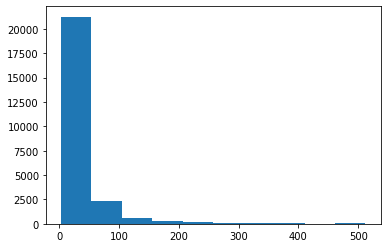

0.94% of the contents contain less than100 tokens


In [14]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
nb_tokens = []
tokenized = tokenizer(df.content.tolist(),truncation=True, max_length=512)
for input_ids in tokenized['input_ids']:
  nb_tokens.append(len(input_ids))
plt.hist(nb_tokens)
plt.show()
print('{}% of the contents contain less than100 tokens'.format(round(sum(map(lambda x: x<=100, nb_tokens))/len(nb_tokens),2)))


I choose to encode the input sequence using **100 tokens**.

In [15]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
train, y_train, val, y_val = create_dataset(df, tokenizer)
train_dataset = Sentiment_analysis_dataset(train, y_train)
val_dataset = Sentiment_analysis_dataset(val, y_val)
training_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)

### **Train**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels = 3)
model.to(device) 
model.train()

In [18]:
optimizer = AdamW(model.parameters(), lr = 5e-5)
model_saver = ModelSaver('xlmr_original')
early_stopping = EarlyStopping()

In [ ]:
num_epochs = 30
model.to(device) 
for epoch in range(num_epochs):
  model.train()
  for param in model.base_model.parameters():
    param.requires_grad = False

  print(epoch+1)
  running_loss = 0.0
  for batch in training_loader:
    
    input_ids = batch['input_ids'].to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
    labels = batch['labels'].to(device, dtype = torch.long)
    outputs = model(input_ids, attention_mask)
    loss = loss_fn(outputs.logits, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
  
  print('evaluating ..')
  eval_loss = 0.0
  model.eval()
  eval_loss, f1_score = eval(model, val_loader)
  model_saver.save(model, eval_loss)
  if early_stopping.step(eval_loss):
    print('early stoppong the training')
    break
    

## **Fine tuning xlm-r tweets**

### **Definig the model**

In [ ]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.to(device)
model.train()


### **Creating dataloaders**

In [ ]:
train, y_train, val, y_val = create_dataset(df, tokenizer)
train_dataset = Sentiment_analysis_dataset(train, y_train)
val_dataset = Sentiment_analysis_dataset(val, y_val)
training_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)

### **Train**

In [21]:
optimizer = AdamW(model.parameters(), lr = 5e-5)
model_saver = ModelSaver('xlmr_tweets_fine_tuned')
early_stopping = EarlyStopping()

In [ ]:

num_epochs = 30
model.to(device) 
for epoch in range(num_epochs):
  model.train()
  for param in model.base_model.parameters():
    param.requires_grad = False

  print(epoch+1)
  running_loss = 0.0
  for batch in training_loader:
    
    input_ids = batch['input_ids'].to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
    labels = batch['labels'].to(device, dtype = torch.long)
    outputs = model(input_ids, attention_mask)
    loss = loss_fn(outputs.logits, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
  
  print('evaluating ..')
  
  model.eval()
  eval_loss, f1_score = eval(model, val_loader)
  model_saver.save(model, eval_loss)
  if early_stopping.step(eval_loss):
    print('early stoppong the training')
    break


## **Fine tuning Deberta**

### **Defining the model**

In [26]:
deberta = f'microsoft/mdeberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(deberta)
model = AutoModelForSequenceClassification.from_pretrained(deberta, num_labels = 3)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/534M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

### **Creating dataloaders**

In [ ]:
train, y_train, val, y_val = create_dataset(df, tokenizer)
train_dataset = Sentiment_analysis_dataset(train, y_train)
val_dataset = Sentiment_analysis_dataset(val, y_val)
training_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)

### **Train**

In [ ]:
optimizer = AdamW(model.parameters(), lr = 5e-5)
early_stopping = EarlyStopping()
model_saver = ModelSaver('deberta')


In [ ]:
num_epochs = 30
model.to(device) 
for epoch in range(num_epochs):
  model.train()
  for param in model.base_model.parameters():
    param.requires_grad = False

  print(epoch+1)
  running_loss = 0.0
  for batch in training_loader:
    
    input_ids = batch['input_ids'].to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
    labels = batch['labels'].to(device, dtype = torch.long)
    outputs = model(input_ids, attention_mask)
    loss = loss_fn(outputs.logits, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
  
  print('evaluating ..')
  
  model.eval()
  eval_loss, f1_score = eval(model, val_loader)
  model_saver.save(model, eval_loss)
  if early_stopping.step(eval_loss):
    print('early stoppong the training')
    break


1
evaluating ..
2
evaluating ..
3
evaluating ..
4
evaluating ..
5
evaluating ..
6
evaluating ..
7
evaluating ..
8
evaluating ..
9
evaluating ..
10
evaluating ..
11
evaluating ..
12
evaluating ..
13
evaluating ..
14
evaluating ..
early stoppong the training


# **Evaluating models**

During the training, we save the checkpoints of the models with the best performances Next, for each model we reload the best checkpoint and evaluate it on the validation dataset.

In [27]:
scores = {}
models_outputs = {}
models_names = ['xlmr_original','xlmr_tweets_fine_tuned', 'deberta', 
                'xlmr_tweets_original']

model_to_tokenizer = {'xlmr_original': 'xlm-roberta-base',
                      'xlmr_tweets_fine_tuned':'cardiffnlp/twitter-xlm-roberta-base-sentiment',
                      'deberta': 'microsoft/mdeberta-v3-base'
                      }


In [ ]:
softmax = torch.nn.Softmax(dim=1)
for model_name in models_names:
  if model_name == 'xlmr_tweets_original':
    MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL,
                                                               num_labels=3)
    
  else:
    model = AutoModelForSequenceClassification\
            .from_pretrained(model_to_tokenizer[model_name],
                             num_labels=3)
            
    model.load_state_dict(torch.load('best_model_{}.pth'.format(model_name),
                                     map_location=torch.device(device)))
    tokenizer = AutoTokenizer.from_pretrained(model_to_tokenizer[model_name])
  
  
  model.to(device)
  model.eval()

  train, y_train, val, y_val = create_dataset(df, tokenizer)
  val_dataset = Sentiment_analysis_dataset(val, y_val)
  val_loader = DataLoader(val_dataset, **test_params)

  final_outputs=[]
  for batch in val_loader:
    input_ids = batch['input_ids'].to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
    labels = batch['labels'].to(device, dtype = torch.long)
    outputs = model(input_ids, attention_mask)
    final_outputs.extend(softmax(outputs.logits).cpu().detach().numpy().tolist())
  y_pred = np.argmax(final_outputs, axis=1)
  f1_score = metrics.f1_score(y_val, y_pred, average='micro')
  precision = metrics.precision_score(y_val, y_pred, average = None).tolist()
  recall = metrics.recall_score(y_val, y_pred, average = None).tolist()
  scores[model_name] = {"f1_score": f1_score,
                        "precision": precision,
                        "recall": recall
                    }
  models_outputs[model_name] = final_outputs
  del model

## Analysing results

In [31]:
results = pd.DataFrame(scores).T
results['precision_negatives'] = results.precision.apply(lambda x: round(float(x[0]),2))
results['precision_neutral'] = results.precision.apply(lambda x: round(float(x[1]),2))
results['precision_positives'] = results.precision.apply(lambda x: round(float(x[2]),2))
results['recall_negatives'] = results.recall.apply(lambda x: round(float(x[0]),2))
results['recall_neutral'] = results.recall.apply(lambda x: round(float(x[1]),2))
results['recall_positives'] = results.recall.apply(lambda x: round(float(x[2]),2))
results.drop(['precision', 'recall'], axis=1)


,accuracy,f1_score,precision_negatives,precision_neutral,precision_positives,recall_negatives,recall_neutral,recall_positives
xlmr_original,0.3114,0.3114,0.32,0.05,0.28,0.80,0.00,0.15
deberta,0.6532,0.6532,0.70,0.87,0.51,0.20,0.87,0.87
xlmr_tweets_original,0.67,0.67,0.64,0.63,0.75,0.75,0.56,0.71
xlmr_tweets_fine_tuned,0.855,0.855,0.82,0.93,0.82,0.85,0.89,0.82



*   We can see that no matter what metric we choose, the model obtained by 
further fine-tuning the xlm-r tweets is the best one. This doesn't come as a surprise since this language model was pre-trained on **domain specific** data.

* We can see that even if xlm-r was pre-trained and fine-tuned on social media data (the case of xlm_tweets_original) further fine-tuning to obtain xlmr_tweets_fine_tuned **reduce by half the error.**



*   Fine-tuning xlm-r from scratch give surprisingly poor results compared to deberta even if those two models have been pre-trained and finetuned on exactly the same data but using different techniques. 

------>  I look deeper into the results of  xlmr_tweets_fine_tuned in the notebook evaluation.



**Training the final model**

Once the evaluation is done, we fine-tune the model but this time using the whole dataset. This time, we do not use early stopping since there will be no validation data. However, we train the model for 9 epochs whcih is the optimal number of epochs obtained by the early stopping method applied to the training with only the train_dataset. 


In [ ]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.to(device)
model.train()
train_encodings = tokenizer(list(df['content']),
                            truncation=True,
                            padding=True,
                            max_length=512)

train, y_train, val, y_val = create_dataset(df, tokenizer)
train_dataset = Sentiment_analysis_dataset(train_encodings,
                                           list(df['sentiment']))
training_loader = DataLoader(train_dataset, **train_params)
optimizer = AdamW(model.parameters(), lr = 5e-5)


In [ ]:

num_epochs = 9
model.to(device) 
for epoch in range(num_epochs):
  model.train()
  for param in model.base_model.parameters():
    param.requires_grad = False

  print(epoch+1)
  running_loss = 0.0
  for batch in training_loader:
    
    input_ids = batch['input_ids'].to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
    labels = batch['labels'].to(device, dtype = torch.long)
    outputs = model(input_ids, attention_mask)
    loss = loss_fn(outputs.logits, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()


torch.save(model.state_dict(), 'checkpoint.pth')